ShapeDetection

Based on __[jrieke / shape-detection](https://github.com/jrieke/shape-detection/blob/master/single-rectangle.ipynb)__

In [1]:
import numpy as np

img_size = 8
min_object_size = 1
max_object_size = 4

def make_image(img):
    if np.random.rand(1) <= 0.2:
        exists = 0.0
        bbox = [0.0, 0.0, 0.0, 0.0]
    else:
        exists = 1.0
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        img[x:x+w, y:y+h] = 1.  # set rectangle to 1
        bbox = [x, y, w, h]
    return (exists, bbox)

In [2]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0
exists = np.zeros((num_imgs, 1))
bboxes = np.zeros((num_imgs, 4))   # x, y, w, h

for i_img in range(num_imgs):
    exists[i_img], bboxes[i_img] = make_image(imgs[i_img])
    
# print(imgs[0])
# print(exists[0])
# print(bboxes[0])

In [3]:
# Reshape to match the input shape of the neural network.
X = imgs.reshape(num_imgs, -1)
X.shape

(50000, 64)

In [4]:
def split_train_test(data):
    i = int(0.8 * num_imgs)
    train_data = data[ :i ]
    test_data = data[ i: ]
    return (train_data, test_data)

In [5]:
# Split training and test.
train_X, test_X = split_train_test(X)
train_y_exists, test_y_exists = split_train_test(exists)
train_y_bboxes, test_y_bboxes = split_train_test(bboxes)
train_imgs, test_imgs = split_train_test(imgs)

In [6]:
from keras.losses import binary_crossentropy, mean_absolute_error
import tensorflow as tf

y_true_exists = None
    
def exists_loss(y_true, y_pred):
    global y_true_exists
    y_true_exists = tf.transpose(y_true[ : , 0])
    return binary_crossentropy(y_true, y_pred)

def bboxes_loss(y_true, y_pred):
    global y_true_exists
    return y_true_exists * mean_absolute_error(y_true, y_pred)

Using TensorFlow backend.


1 つ目の Dense
  - 入力が 64
  - ニューロンが 200
  - ウエイトの数は 64 x 200 = 12,800、バイアスが 200、パラメータ数の合計は 12,800 + 200 = 13,000。

2 つ目の Dense
  - 入力が 200
  - ニューロンが 5
  - ウエイトの数は 200 x 5 = 1,000、バイアスが 5、パラメータ数の合計は 1,000 + 5 = 1,005。

In [7]:
# Build the model.
from keras.models import Model
from keras.layers import Input, Dense, Dropout
# from keras.optimizers import SGD

inputs = Input(shape=(X.shape[-1], ), name='Input')
x = Dense(200, activation='relu', name='Dense_1')(inputs)
x = Dropout(0.2, name='Dropout_1')(x)
exists = Dense(1, activation='sigmoid', name='exists')(x)
bbox = Dense(4, activation='linear', name='bbox')(x)

model = Model(inputs=inputs, outputs=[exists, bbox])
model.compile(
    'adadelta', 
    loss={'exists': exists_loss, 'bbox': bboxes_loss})
    # loss={'exists': 'binary_crossentropy', 'bbox': 'mean_absolute_error'})
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 64)           0                                            
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 200)          13000       Input[0][0]                      
__________________________________________________________________________________________________
Dropout_1 (Dropout)             (None, 200)          0           Dense_1[0][0]                    
__________________________________________________________________________________________________
exists (Dense)       

In [8]:
# Train.
model.fit(
    train_X, [train_y_exists, train_y_bboxes], epochs=10,
    validation_data=(test_X, [test_y_exists, test_y_bboxes]), verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.4547 - exists_loss: 0.0814 - bbox_loss: 0.3734 - val_loss: 0.1381 - val_exists_loss: 0.0082 - val_bbox_loss: 0.1298
Epoch 2/10
 - 3s - loss: 0.1791 - exists_loss: 0.0047 - bbox_loss: 0.1745 - val_loss: 0.0821 - val_exists_loss: 0.0022 - val_bbox_loss: 0.0798
Epoch 3/10
 - 3s - loss: 0.1488 - exists_loss: 0.0019 - bbox_loss: 0.1469 - val_loss: 0.0670 - val_exists_loss: 0.0012 - val_bbox_loss: 0.0659
Epoch 4/10
 - 3s - loss: 0.1375 - exists_loss: 0.0012 - bbox_loss: 0.1363 - val_loss: 0.0591 - val_exists_loss: 7.8472e-04 - val_bbox_loss: 0.0583
Epoch 5/10
 - 3s - loss: 0.1306 - exists_loss: 8.9072e-04 - bbox_loss: 0.1297 - val_loss: 0.0516 - val_exists_loss: 6.3841e-04 - val_bbox_loss: 0.0509
Epoch 6/10
 - 3s - loss: 0.1267 - exists_loss: 7.6058e-04 - bbox_loss: 0.1260 - val_loss: 0.0494 - val_exists_loss: 5.4504e-04 - val_bbox_loss: 0.0489
Epoch 7/10
 - 3s - loss:

In [9]:
# Predict bounding boxes existance and the location on the test images.
pred_exists, pred_bboxes = model.predict(test_X)

In [10]:
def IOU(exists1, exists2, bbox1, bbox2):
    '''
    Calculate overlap between two bounding boxes [x, y, w, h]
    as the area of intersection over the area of unity
    '''
    if 0.5 <= exists1 and 0.5 <= exists2:
        x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
        x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

        w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
        h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
        if w_I <= 0 or h_I <= 0:  # no overlap
            return 0.
        I = w_I * h_I
        U = w1 * h1 + w2 * h2 - I

        return I / U
    else:
        if exists1 < 0.5 and exists2 < 0.5:
            return 1.0
        else:
            return 0.0

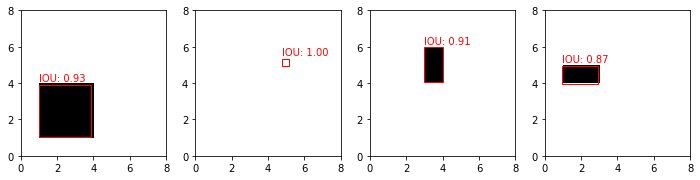

In [11]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(
        test_imgs[i].T, cmap='Greys', interpolation='none',
        origin='lower', extent=[0, img_size, 0, img_size])
    pred_bbox, test_bbox, pred_exist, test_exist = \
            pred_bboxes[i], test_y_bboxes[i], pred_exists[i], test_y_exists[i]
    plt.gca().add_patch(matplotlib.patches.Rectangle(
        (pred_bbox[0], pred_bbox[1]),
        pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
    iou = IOU(pred_exist, test_exist, pred_bbox, test_bbox)
    plt.annotate(
        'IOU: {:.2f}'.format(iou),
        (max(0.0, pred_bbox[0]), pred_bbox[1]+pred_bbox[3]+0.2), color='r')

plt.show()
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [12]:
# Calculate the mean IOU (overlap) between the predicted and expected
# bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox, pred_exist, test_exist in \
        zip(pred_bboxes, test_y_bboxes, pred_exists, test_y_exists):
    summed_IOU += IOU(pred_exist, test_exist, pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
print("Mean IOU: {0:.3f}".format(mean_IOU))

Mean IOU: 0.876
